In [8]:
import gzip
import json

import time
from datetime import datetime

import pandas as pd
import numpy as np

import sklearn as skl

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD

warnings.filterwarnings("ignore")
%matplotlib inline

# EDA

In [9]:
#получение данных из источника, отбор по unixReviewTime

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

data_review_all = getDF('/home/dataengineer/OTUS_ML/rs_data/Digital_Music.json.gz')
data_review_all = data_review_all[data_review_all['unixReviewTime'] >= 1420070400]

In [10]:
#оценка количества отзывов по товарам

data_i = data_review_all.groupby('asin').agg(reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'))
data_i_r = data_i.groupby('reviews_total').agg(reviews_total_count = pd.NamedAgg(column = 'reviews_total', aggfunc = 'count'))   
data_i_r

,reviews_total_count
reviews_total,
1,187370
2,38586
3,15131
4,8193
5,5012
...,...
1311,1
1363,1
1463,1


In [11]:
#оценка количества отзывов по пользователям

data_u = data_review_all.groupby('reviewerID').agg(reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'))
data_u_r = data_u.groupby('reviews_total').agg(reviews_total_count = pd.NamedAgg(column = 'reviews_total', aggfunc = 'count'))   
data_u_r

,reviews_total_count
reviews_total,
1,336579
2,60445
3,20527
4,9908
5,5809
...,...
364,1
373,1
416,1


In [12]:
#отбор по количеству отзывов

filter_users = data_review_all['reviewerID'].value_counts() >= 4
filter_users = filter_users[filter_users].index.tolist()

filter_items = data_review_all['asin'].value_counts() >= 4
filter_items = filter_items[filter_items].index.tolist()

data_review = data_review_all[(data_review_all['reviewerID'].isin(filter_users)) & (data_review_all['asin'].isin(filter_items))]

print('The original data frame shape:\t{}'.format(data_review_all.shape))
print('The new data frame shape:\t{}'.format(data_review.shape))

The original data frame shape:	(792764, 12)
The new data frame shape:	(157442, 12)


In [13]:
#предварительная обработка фактов

data_review['overall'] = data_review['overall'].astype(int)

data_review['r'] = data_review['overall']
data_review = pd.get_dummies(data_review, columns=['r'])

data_review['rewiev_len'] = data_review['reviewText'].str.split().str.len().fillna(0).astype(int)

data_review['m'] = pd.to_datetime(data_review['unixReviewTime'],unit='s').dt.month
data_review = pd.get_dummies(data_review, columns=['m'])

data_review = data_review.drop(['verified', 'vote', 'reviewTime', 'style', 'reviewerName', 'summary', 'image', 'reviewText'], axis=1)

data_review.info()
data_review.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157442 entries, 149 to 1584057
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         157442 non-null  int64 
 1   reviewerID      157442 non-null  object
 2   asin            157442 non-null  object
 3   unixReviewTime  157442 non-null  int64 
 4   r_1             157442 non-null  uint8 
 5   r_2             157442 non-null  uint8 
 6   r_3             157442 non-null  uint8 
 7   r_4             157442 non-null  uint8 
 8   r_5             157442 non-null  uint8 
 9   rewiev_len      157442 non-null  int64 
 10  m_1             157442 non-null  uint8 
 11  m_2             157442 non-null  uint8 
 12  m_3             157442 non-null  uint8 
 13  m_4             157442 non-null  uint8 
 14  m_5             157442 non-null  uint8 
 15  m_6             157442 non-null  uint8 
 16  m_7             157442 non-null  uint8 
 17  m_8             157442 non

,overall,reviewerID,asin,unixReviewTime,r_1,r_2,r_3,r_4,r_5,rewiev_len,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
149,5,A16TZRNJAH1V0B,0006920055,1442448000,0,0,0,0,1,4,...,0,0,0,0,0,0,1,0,0,0
153,5,A1U1V9U9IS8F5B,0006920055,1420329600,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
249,5,A2REF5NAGDO02L,1932192077,1509321600,0,0,0,0,1,34,...,0,0,0,0,0,0,0,1,0,0
268,5,A20YI9KACZBL2I,1932192077,1489276800,0,0,0,0,1,4,...,1,0,0,0,0,0,0,0,0,0
385,5,A28GENP8GFM864,5552256646,1465948800,0,0,0,0,1,11,...,0,0,0,1,0,0,0,0,0,0


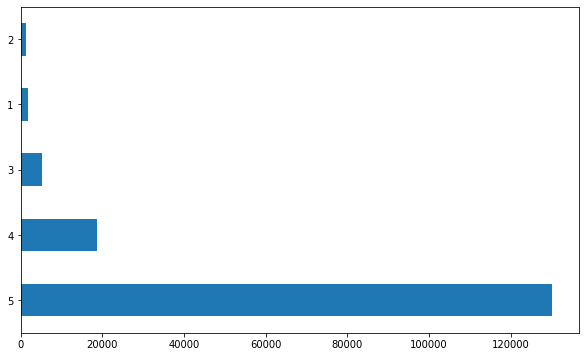

In [14]:
#оценка распределения рейтингов

r_plot = data_review['overall'].value_counts()
r_plot.plot(kind='barh', figsize=(10, 6))
plt.show()  

# Clustering

## Preprocessing & Feature Engineering

In [15]:
#подготовка данных для кластеризации users

data_for_clustering = data_review.groupby('reviewerID').agg(
    reviews_total = pd.NamedAgg(column = 'overall', aggfunc = 'count'),
    r_1_total = pd.NamedAgg(column = 'r_1', aggfunc = 'sum'),
    r_2_total = pd.NamedAgg(column = 'r_2', aggfunc = 'sum'),
    r_3_total = pd.NamedAgg(column = 'r_3', aggfunc = 'sum'),
    r_4_total = pd.NamedAgg(column = 'r_4', aggfunc = 'sum'),
    r_5_total = pd.NamedAgg(column = 'r_5', aggfunc = 'sum'),
    review_len_med = pd.NamedAgg(column = 'rewiev_len', aggfunc = 'median'),
    time_first_review = pd.NamedAgg(column = 'unixReviewTime', aggfunc = 'min'),
    time_last_review = pd.NamedAgg(column = 'unixReviewTime', aggfunc = 'max'),
    m_1_total = pd.NamedAgg(column = 'm_1', aggfunc = 'sum'),
    m_2_total = pd.NamedAgg(column = 'm_2', aggfunc = 'sum'),
    m_3_total = pd.NamedAgg(column = 'm_3', aggfunc = 'sum'),
    m_4_total = pd.NamedAgg(column = 'm_4', aggfunc = 'sum'),
    m_5_total = pd.NamedAgg(column = 'm_5', aggfunc = 'sum'),
    m_6_total = pd.NamedAgg(column = 'm_6', aggfunc = 'sum'),
    m_7_total = pd.NamedAgg(column = 'm_7', aggfunc = 'sum'),
    m_8_total = pd.NamedAgg(column = 'm_8', aggfunc = 'sum'),
    m_9_total = pd.NamedAgg(column = 'm_9', aggfunc = 'sum'),
    m_10_total = pd.NamedAgg(column = 'm_10', aggfunc = 'sum'),
    m_11_total = pd.NamedAgg(column = 'm_11', aggfunc = 'sum'),
    m_12_total = pd.NamedAgg(column = 'm_12', aggfunc = 'sum')
    )

data_for_clustering['lt_days'] = (data_for_clustering['time_last_review'] - data_for_clustering['time_first_review']) / 86400 + 1
data_for_clustering = data_for_clustering[data_for_clustering['lt_days'] > 1]
data_for_clustering = data_for_clustering.drop(['time_first_review', 'time_last_review'], axis=1)

data_for_clustering.reset_index(inplace=True)

data_for_clustering

,reviewerID,reviews_total,r_1_total,r_2_total,r_3_total,r_4_total,r_5_total,review_len_med,m_1_total,m_2_total,...,m_4_total,m_5_total,m_6_total,m_7_total,m_8_total,m_9_total,m_10_total,m_11_total,m_12_total,lt_days
0,A0081575F2F9XQSSIYA3,11,0,0,2,3,6.0,21.0,0,0,...,0,0,0,0,0,3,8,0,0,56.0
1,A0108129TLIKAX34M8AA,2,0,0,0,0,2.0,3.5,0,0,...,0,2,0,0,0,0,0,0,0,8.0
2,A01241534EPLP5O3KOP5,3,0,0,0,0,3.0,8.0,3,0,...,0,0,0,0,0,0,0,0,0,733.0
3,A0422204VM5KZUEMVY96,3,0,0,0,0,3.0,2.0,0,0,...,0,0,0,0,1,0,0,0,2,247.0
4,A1004Y5QBQEGA3,3,0,0,0,0,3.0,30.0,0,1,...,1,0,0,0,0,0,0,0,0,1144.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17771,AZYL2RTHUWR0P,3,0,0,0,0,3.0,3.0,0,0,...,0,0,0,0,1,0,0,2,0,111.0
17772,AZYOVGJLQ03ML,10,0,0,3,0,7.0,8.0,1,0,...,0,0,0,1,0,3,1,0,4,188.0
17773,AZYVCAJ8O71NK,4,0,0,0,0,4.0,34.5,0,0,...,2,0,0,0,0,2,0,0,0,751.0
17774,AZYWYG2YYXH7O,2,0,0,0,0,2.0,2.0,0,0,...,1,0,1,0,0,0,0,0,0,305.0


In [16]:
#стандартизация

data_for_clustering_sc = StandardScaler().fit_transform(data_for_clustering[['reviews_total', 'r_1_total', 'r_2_total', 'r_3_total', 'r_4_total',
                                                           'r_5_total', 'lt_days', 'review_len_med',
                                                           'm_1_total', 'm_2_total', 'm_3_total', 'm_4_total', 'm_5_total', 'm_6_total',
                                                           'm_7_total', 'm_8_total', 'm_9_total', 'm_10_total', 'm_11_total', 'm_12_total',]])

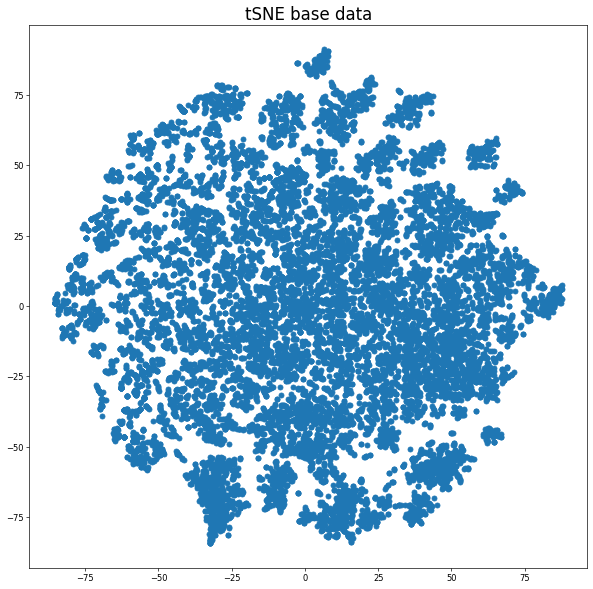

In [17]:
#визуализация исходных данных в сжатом признаковом пространстве tSNE

data_for_clustering_tsne = TSNE(n_components=2, random_state=42, n_jobs=-1).fit_transform(data_for_clustering_sc)

plt.figure(figsize=(12, 12), dpi= 60)
plt.title("tSNE base data", fontsize=20)
plt.scatter(data_for_clustering_tsne[:, 0], data_for_clustering_tsne[:, 1])

## Modelling

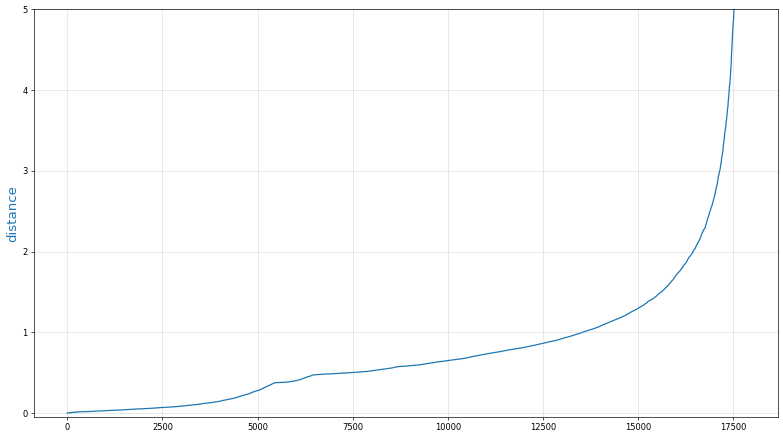

In [18]:
#нахождение оптимального значения eps с помощью NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_for_clustering_sc)
distances, indices = nbrs.kneighbors(data_for_clustering_sc)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig, ax = plt.subplots(1,1,figsize=(16,9), dpi= 60)
ax.set_ylabel('distance', color='tab:blue', fontsize=16)
ax.grid(alpha=.4)
ax.set_ylim(ymin=-0.05, ymax=5)
plt.plot(distances)

In [19]:
#построение модели DBSCAN

db = DBSCAN(eps=1.5, min_samples=17)
db.fit(data_for_clustering_sc)

data_for_clustering_labels = db.labels_

n_clusters = len(set(data_for_clustering_labels)) - (1 if -1 in data_for_clustering_labels else 0)
print("Clusters total: " + str(n_clusters))

Clusters total: 3


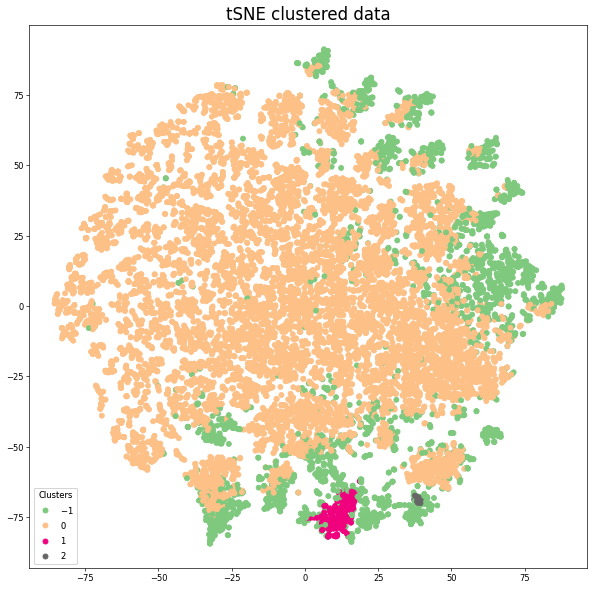

In [20]:
#визуализация результатов кластеризации в сжатом признаковом пространстве tSNE

fig, ax = plt.subplots(figsize=(12, 12), dpi= 60)

plt.title("tSNE clustered data", fontsize=20)
scatter = ax.scatter(data_for_clustering_tsne[:, 0], data_for_clustering_tsne[:, 1], c = data_for_clustering_labels, cmap="Accent")
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Clusters")
ax.add_artist(legend)

In [21]:
#добавление ID кластера

data_for_clustering['clusterID'] = data_for_clustering_labels
data_for_clustering

,reviewerID,reviews_total,r_1_total,r_2_total,r_3_total,r_4_total,r_5_total,review_len_med,m_1_total,m_2_total,...,m_5_total,m_6_total,m_7_total,m_8_total,m_9_total,m_10_total,m_11_total,m_12_total,lt_days,clusterID
0,A0081575F2F9XQSSIYA3,11,0,0,2,3,6.0,21.0,0,0,...,0,0,0,0,3,8,0,0,56.0,-1
1,A0108129TLIKAX34M8AA,2,0,0,0,0,2.0,3.5,0,0,...,2,0,0,0,0,0,0,0,8.0,0
2,A01241534EPLP5O3KOP5,3,0,0,0,0,3.0,8.0,3,0,...,0,0,0,0,0,0,0,0,733.0,0
3,A0422204VM5KZUEMVY96,3,0,0,0,0,3.0,2.0,0,0,...,0,0,0,1,0,0,0,2,247.0,0
4,A1004Y5QBQEGA3,3,0,0,0,0,3.0,30.0,0,1,...,0,0,0,0,0,0,0,0,1144.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17771,AZYL2RTHUWR0P,3,0,0,0,0,3.0,3.0,0,0,...,0,0,0,1,0,0,2,0,111.0,0
17772,AZYOVGJLQ03ML,10,0,0,3,0,7.0,8.0,1,0,...,0,0,1,0,3,1,0,4,188.0,-1
17773,AZYVCAJ8O71NK,4,0,0,0,0,4.0,34.5,0,0,...,0,0,0,0,2,0,0,0,751.0,0
17774,AZYWYG2YYXH7O,2,0,0,0,0,2.0,2.0,0,0,...,0,1,0,0,0,0,0,0,305.0,0


In [22]:
#оценка распределения по кластерам

data_for_clustering_by_clusters = data_for_clustering.groupby('clusterID').agg(
    elements_total = pd.NamedAgg(column = 'clusterID', aggfunc = 'count'),
    reviews_mean = pd.NamedAgg(column = 'reviews_total', aggfunc = 'mean'),
    r_1_mean = pd.NamedAgg(column = 'r_1_total', aggfunc = 'mean'),
    r_2_mean = pd.NamedAgg(column = 'r_2_total', aggfunc = 'mean'),
    r_3_mean = pd.NamedAgg(column = 'r_3_total', aggfunc = 'mean'),
    r_4_mean = pd.NamedAgg(column = 'r_4_total', aggfunc = 'mean'),
    r_5_mean = pd.NamedAgg(column = 'r_5_total', aggfunc = 'mean'),
    review_len_med_mean = pd.NamedAgg(column = 'review_len_med', aggfunc = 'median'),
    lt_days_mean = pd.NamedAgg(column = 'lt_days', aggfunc = 'median'),
    m_1_mean = pd.NamedAgg(column = 'm_1_total', aggfunc = 'mean'),
    m_2_mean = pd.NamedAgg(column = 'm_2_total', aggfunc = 'mean'),
    m_3_mean = pd.NamedAgg(column = 'm_3_total', aggfunc = 'mean'),
    m_4_mean = pd.NamedAgg(column = 'm_4_total', aggfunc = 'mean'),
    m_5_mean = pd.NamedAgg(column = 'm_5_total', aggfunc = 'mean'),
    m_6_mean = pd.NamedAgg(column = 'm_6_total', aggfunc = 'mean'),
    m_7_mean = pd.NamedAgg(column = 'm_7_total', aggfunc = 'mean'),
    m_8_mean = pd.NamedAgg(column = 'm_8_total', aggfunc = 'mean'),
    m_9_mean = pd.NamedAgg(column = 'm_9_total', aggfunc = 'mean'),
    m_10_mean = pd.NamedAgg(column = 'm_10_total', aggfunc = 'mean'),
    m_11_mean = pd.NamedAgg(column = 'm_11_total', aggfunc = 'mean'),
    m_12_mean = pd.NamedAgg(column = 'm_12_total', aggfunc = 'mean'),
    )

data_for_clustering_by_clusters.sort_values(by=['elements_total'], ascending=False)

,elements_total,reviews_mean,r_1_mean,r_2_mean,r_3_mean,r_4_mean,r_5_mean,review_len_med_mean,lt_days_mean,m_1_mean,...,m_3_mean,m_4_mean,m_5_mean,m_6_mean,m_7_mean,m_8_mean,m_9_mean,m_10_mean,m_11_mean,m_12_mean
clusterID,,,,,,,,,,,,,,,,,,,,,
0,14551,4.365954,0.025290,0.000000,0.093671,0.415848,3.831146,8.0,301.0,0.384235,...,0.467528,0.365542,0.441413,0.413442,0.398735,0.397498,0.319634,0.303072,0.243351,0.219916
-1,2914,17.956760,0.324296,0.282773,0.830130,2.813658,13.705903,7.0,522.0,1.606040,...,1.810226,1.608785,1.774537,1.579959,1.474949,1.509952,1.373713,1.351407,1.115305,1.073782
1,284,3.746479,0.000000,1.000000,0.190141,0.517606,2.038732,14.0,293.0,0.338028,...,0.461268,0.302817,0.341549,0.362676,0.327465,0.313380,0.316901,0.320423,0.186620,0.154930
2,27,2.851852,2.000000,0.000000,0.037037,0.111111,0.703704,13.0,150.0,0.222222,...,0.333333,0.074074,0.333333,0.296296,0.555556,0.259259,0.185185,0.259259,0.037037,0.185185


# Рекомендательные системы

## Preprocessing & Feature Engineering

In [23]:
#получение набора данных для рекомендательных систем с clusterID

data_rs = pd.merge(data_review[['reviewerID', 'asin', 'overall']], data_for_clustering[['reviewerID', 'clusterID']], on='reviewerID', how='outer')
data_rs = data_rs[data_rs.clusterID.notna()]
data_rs

,reviewerID,asin,overall,clusterID
0,A16TZRNJAH1V0B,0006920055,5,-1.0
1,A16TZRNJAH1V0B,B00920DU6A,5,-1.0
2,A16TZRNJAH1V0B,B00VG2QNFM,5,-1.0
3,A16TZRNJAH1V0B,B0058V8SDW,5,-1.0
4,A16TZRNJAH1V0B,B008723K96,5,-1.0
...,...,...,...,...
157336,A1PCUXWTQG11KZ,B01GGAHUB4,5,0.0
157377,A2QOBD1Q0G3G4Q,B01F542D3W,5,0.0
157378,A2QOBD1Q0G3G4Q,B01FN74YWE,5,0.0
157406,A101ZRM7NIDMW2,B01G33LNPI,5,0.0


## Modelling

In [24]:
#функция для подбора оптимальных параметров и проверки качества предсказаний

def rs_gs_cv (data, input_columns, rating_scale, param_grid):
 
    reader = Reader(rating_scale = r_scale)
    data = Dataset.load_from_df(data[input_columns], reader)

    param_grid = param_grid
    gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5)

    gs.fit(data)

    results = pd.DataFrame.from_dict(gs.best_params)
    results.reset_index(inplace=True)
    results = pd.pivot_table(results, columns = 'index', values = 'rmse')
    results.insert(0, 'score', gs.best_score['rmse'])
   
    trainset, testset = train_test_split(data, test_size=0.25)
    model = gs.best_estimator['rmse']
    predictions = model.fit(trainset).test(testset)

    data_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
    data_pred['err'] = abs(data_pred.est - data_pred.rui)
    data_pred = data_pred[['uid', 'iid', 'rui', 'est', 'err', 'details']]
               
    return results, data_pred

In [25]:
#аргументы функции

n_factors_values = list(range(20, 220, 20))
prm_grid = {'n_factors':[40,80,120,160], 'n_epochs':[20,30,40]}
r_scale = (1, 5)
clusters_arr = data_rs.clusterID.sort_values().unique()
cols = ['reviewerID', 'asin', 'overall']

### Подбор оптимальных параметров и проверка качества предсказаний по кластерам

In [26]:
#подбор оптимальных параметров и проверка качества предсказаний для каждого кластера

results_by_clusters = pd.DataFrame()
predictions_by_clusters = pd.DataFrame()

for cluster in clusters_arr:
    
    data_rs_c = data_rs[data_rs['clusterID'] == cluster]
    
    results_c, predictions_c = rs_gs_cv(data_rs_c, cols, r_scale, prm_grid)
    
    results_c.insert(0, 'cluster', cluster)
    results_c = results_c.set_index('cluster')    
    results_by_clusters = pd.concat([results_by_clusters, results_c])
    
    predictions_c.insert(0, 'cluster', cluster)
    predictions_c = predictions_c.set_index('cluster')    
    predictions_by_clusters = pd.concat([predictions_by_clusters, predictions_c])

In [27]:
#оптимальные параметры для каждого кластера

results_by_clusters

index,score,n_epochs,n_factors
cluster,,,
-1.0,0.637499,40,80
0.0,0.480895,30,40
1.0,1.332519,20,160
2.0,1.823714,20,160


In [28]:
#предсказания по кластерам

predictions_by_clusters

,uid,iid,rui,est,err,details
cluster,,,,,,
-1.0,A3W4D8XOGLWUN5,B00136NK2K,5.0,3.477384,1.522616,{'was_impossible': False}
-1.0,A1PR9PF2Y0B0DY,B00KAYYHBO,5.0,4.923235,0.076765,{'was_impossible': False}
-1.0,ASL61YP0GQGBB,B00O6L3IWG,5.0,4.941563,0.058437,{'was_impossible': False}
-1.0,ATZ2QEHHG0XT5,B00QYCHUKG,4.0,3.816615,0.183385,{'was_impossible': False}
-1.0,AXJ6MVJU8UE7R,B00FDYVHNM,5.0,4.666451,0.333549,{'was_impossible': False}
...,...,...,...,...,...,...
2.0,A2K6WD4AT43ORI,B0169FEX6Q,5.0,2.032129,2.967871,{'was_impossible': False}
2.0,ARXWXNI5FMCSQ,B0059H09DC,1.0,2.231904,1.231904,{'was_impossible': False}
2.0,A3CN3QUMI31DVJ,B0170K9UTO,1.0,2.348286,1.348286,{'was_impossible': False}


In [29]:
#RMSE для предсказаний по кластерам

rmse_by_clusters = mean_squared_error(predictions_by_clusters[['rui']], predictions_by_clusters[['est']], squared = False)
'RMSE by clusters: {:.5f}'.format(rmse_by_clusters)

'RMSE by clusters: 0.57605'

### Подбор оптимальных параметров и проверка качества предсказаний для всего набора данных без учета кластеров

In [30]:
#подбор оптимальных параметров и проверка качества предсказаний для всего набора данных без учета кластеров

results_not_clusters, predictions_not_clusters = rs_gs_cv(data_rs, cols, r_scale, prm_grid)

In [31]:
#оптимальные параметры для всего набора данных без учета кластеров

results_not_clusters

index,score,n_epochs,n_factors
rmse,0.581605,40,40


In [32]:
#предсказания для всего набора данных без учета кластеров

predictions_not_clusters

,uid,iid,rui,est,err,details
0,A3IH5L48F016GF,B00DYLVD62,3.0,4.262380,1.262380,{'was_impossible': False}
1,A2IHJOLL493PHQ,B01AIWLIVE,5.0,4.845608,0.154392,{'was_impossible': False}
2,A2HGZRJWEZZTO9,B002HOCPXM,5.0,4.923286,0.076714,{'was_impossible': False}
3,AHB899WWYV0RK,B00181OEZ2,5.0,4.829866,0.170134,{'was_impossible': False}
4,A3QK0YZD1YKOD8,B00LTFDWXW,4.0,4.369667,0.369667,{'was_impossible': False}
...,...,...,...,...,...,...
29244,A17ZLO2I1YULU3,B010PE0LRC,5.0,4.913540,0.086460,{'was_impossible': False}
29245,A1F9455BJ69RJH,B0048VYLR0,5.0,4.945397,0.054603,{'was_impossible': False}
29246,A1O93S8Y9GOS6N,B00W4KNSU8,5.0,4.710434,0.289566,{'was_impossible': False}
29247,ADQ5CXGJXX77J,B00137KH9S,5.0,4.972980,0.027020,{'was_impossible': False}


In [33]:
#RMSE для предсказаний для всего набора данных без учета кластеров

rmse_not_clusters = mean_squared_error(predictions_not_clusters[['rui']], predictions_not_clusters[['est']], squared = False)
'RMSE not by clusters: {:.5f}'.format(rmse_not_clusters)

'RMSE not by clusters: 0.58500'

ВЫВОД

Предварительная кластеризация данных может улучшить результаты работы рекомендательных систем так как позволяет настроить гиперпараметры для каждого кластера по отдельности. Максимальный эффект достигается при наличии существенных различичий данных в кластерах а также достаточных размерах самих кластеров.
В случае, когда выделяется один кластер существенно больше других, сводные метрики качества рекомендательных систем, работающих с каждым 
отдельным кластером и единым набором данных, существенно не различаются.